#  Demo: T-Maze Environment + Learning
This notebook gives a step-by-step demonstration of active inference and learning using the `Agent()` class of `pymdp` and the `TMazeEnv` environment.

For a thorough introduction to the basic `TMazeEnv` used here and active inference _without learning_ in that environment, please see the main `tmaze_demo.ipynb` notebook.

In this particular case, we assume that the contingencies describing the 'rules' of the T-Maze are unknown to the agent, and must be learned. This demo therefore requires understanding the distinction between the agent's _generative model_  and the _generative process_ (the actual rules governing world dynamics).

'Learning' under active inference corresponds to updating posterior beliefs about the sufficient statistics of distributions that parameterize the so-called 'structure' of the generative model. In the case of the Categorical distributions used to represent beliefs about states and outcomes in the discrete space-and-time MDPs used in `pymdp`, these structural parameters correspond to prior beliefs about the sensory and transition likelihoods and priors (the `A`, `B`, `C`, and `D` arrays) of the generative model. 

In the following exercise, we consider the case when an active inference agent needs to learn how sensory cues (the equivalent of a 'conditioned stimulus' or CS in learning theory) indicate the probability of receiving a reward in the two arms of a T-Maze.

### Imports|

First, import `pymdp` and the modules we'll need.

In [4]:
import os
import sys
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = pathlib.Path(os.getcwd())
module_path = str(path.parent) + '/'
sys.path.append(module_path)

from pymdp.agent import Agent
from pymdp import core
from pymdp.distributions import Categorical, Dirichlet
from pymdp.envs import TMazeEnvNullOutcome

### Auxiliary Functions

Define some utility functions that will be helpful for plotting.

In [8]:
def plot_beliefs(belief_dist, title=""):
    values = belief_dist.values[:, 0]
    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), values, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title)
    plt.show()
    
def plot_likelihood(A, title=""):
    ax = sns.heatmap(A.values, cmap="OrRd", linewidth=2.5)
    plt.xticks(range(A.shape[1]))
    plt.yticks(range(A.shape[0]))
    plt.title(title)
    plt.show()

In [9]:
reward_probabilities = [0.7, 0.3] # the 'true' reward probabilities 
env = TMazeEnvNullOutcome(reward_probs = reward_probabilities)
A_gp = env.get_likelihood_dist()
B_gp = env.get_transition_dist()

In [10]:
def construct_dirichlet(template_categorical, prior_scale=1.0):
    """
    Helper function to construct a Dirichlet distribution based on an existing Categorical distribution
    """
    
    if template_categorical.n_arrays > 1:
        dirichlet_values = np.empty(template_categorical.n_arrays, dtype=object)
        for arr_id in range(template_categorical.n_arrays):
            dirichlet_values[arr_id] = prior_scale * template_categorical[arr_id].values
        return Dirichlet(values = dirichlet_values)
    else:
        return Dirichlet(values = prior_scale * template_categorical.values)

In [11]:
pA = construct_dirichlet(A_gp, prior_scale = 1e16)

reward_modality = pA[1].values.copy()
reward_modality[:,1:3,:] = 1.0

pA[1] = reward_modality

cue_modality = pA[2].values.copy()
cue_modality[2,-1,0] = 3.0
cue_modality[1,-1,0] = 2.0

cue_modality[2,-1,1] = 2.0
cue_modality[1,-1,1] = 3.0

pA[2] = cue_modality

A_gm = pA.mean()        

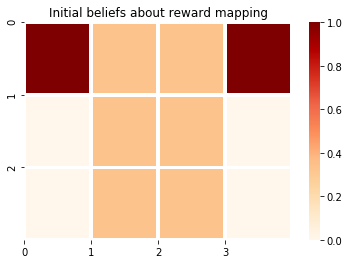

In [12]:
plot_likelihood(A_gm[1][:,:,0],'Initial beliefs about reward mapping')

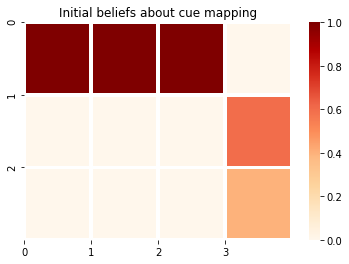

In [13]:
plot_likelihood(A_gm[2][:,:,1],'Initial beliefs about cue mapping')

In [14]:
B_gm = B_gp.copy()

In [15]:
controllable_indices = [0] # this is a list of the indices of the hidden state factors that are controllable
learnable_modalities = [1,2]

In [16]:
agent = Agent(A=A_gm,pA=pA,B=B_gm,
              control_fac_idx=controllable_indices,
              modalities_to_learn=learnable_modalities,
              lr_pA = 0.25,
              use_param_info_gain=True)

In [17]:
agent.D[0] = np.eye(agent.n_states[0])[0]

In [18]:
agent.C[1][1] = 2.0
agent.C[1][2] = -2.0

In [19]:
T = 100 # number of timesteps

obs = env.reset() # reset the environment and get an initial observation

# these are useful for displaying read-outs during the loop over time
reward_conditions = ["Left", "Right"]
location_observations = ['CENTER','RIGHT ARM','LEFT ARM','CUE LOCATION']
reward_observations = ['No reward','Reward!','Loss!']
cue_observations = ['Null','Cue Right','Cue Left']
msg = """ === Starting experiment === \n Reward condition: {}, Observation: [{}, {}, {}]"""
print(msg.format(reward_conditions[env.reward_condition], location_observations[obs[0]], reward_observations[obs[1]], cue_observations[obs[2]]))

pA_history = []
for t in range(T):
    
    pA_t = agent.update_A(obs)
    pA_history.append(pA_t)
    
    qx = agent.infer_states(obs)

    q_pi, efe = agent.infer_policies()

    action = agent.sample_action()

    msg = """[Step {}] Action: [Move to {}]"""
    print(msg.format(t, location_observations[action[0]]))

    obs = env.step(action)

    msg = """[Step {}] Observation: [{},  {}, {}]"""
    print(msg.format(t, location_observations[obs[0]], reward_observations[obs[1]], cue_observations[obs[2]]))

 === Starting experiment === 
 Reward condition: Right, Observation: [CENTER, No reward, Null]
[Step 0] Action: [Move to RIGHT ARM]
[Step 0] Observation: [RIGHT ARM,  Reward!, Null]
[Step 1] Action: [Move to LEFT ARM]
[Step 1] Observation: [LEFT ARM,  Reward!, Null]
[Step 2] Action: [Move to RIGHT ARM]
[Step 2] Observation: [RIGHT ARM,  Reward!, Null]
[Step 3] Action: [Move to RIGHT ARM]
[Step 3] Observation: [RIGHT ARM,  Loss!, Null]
[Step 4] Action: [Move to LEFT ARM]
[Step 4] Observation: [LEFT ARM,  Reward!, Null]
[Step 5] Action: [Move to LEFT ARM]
[Step 5] Observation: [LEFT ARM,  Reward!, Null]
[Step 6] Action: [Move to LEFT ARM]
[Step 6] Observation: [LEFT ARM,  Reward!, Null]
[Step 7] Action: [Move to LEFT ARM]
[Step 7] Observation: [LEFT ARM,  Reward!, Null]
[Step 8] Action: [Move to LEFT ARM]
[Step 8] Observation: [LEFT ARM,  Reward!, Null]
[Step 9] Action: [Move to LEFT ARM]
[Step 9] Observation: [LEFT ARM,  Reward!, Null]
[Step 10] Action: [Move to LEFT ARM]
[Step 10] Obse

/Users/conor/pymdp/pymdp/distributions/categorical.py:371: UserWarning: You have called :log: on a Categorical that contains zeros.                      We have removed zeros by adding a small non-negative scalar to each value.
  We have removed zeros by adding a small non-negative scalar to each value."



[Step 25] Observation: [LEFT ARM,  Reward!, Null]
[Step 26] Action: [Move to LEFT ARM]
[Step 26] Observation: [LEFT ARM,  Loss!, Null]
[Step 27] Action: [Move to LEFT ARM]
[Step 27] Observation: [LEFT ARM,  Reward!, Null]
[Step 28] Action: [Move to LEFT ARM]
[Step 28] Observation: [LEFT ARM,  Reward!, Null]
[Step 29] Action: [Move to LEFT ARM]
[Step 29] Observation: [LEFT ARM,  Loss!, Null]
[Step 30] Action: [Move to LEFT ARM]
[Step 30] Observation: [LEFT ARM,  Reward!, Null]
[Step 31] Action: [Move to LEFT ARM]
[Step 31] Observation: [LEFT ARM,  Reward!, Null]
[Step 32] Action: [Move to LEFT ARM]
[Step 32] Observation: [LEFT ARM,  Reward!, Null]
[Step 33] Action: [Move to LEFT ARM]
[Step 33] Observation: [LEFT ARM,  Reward!, Null]
[Step 34] Action: [Move to LEFT ARM]
[Step 34] Observation: [LEFT ARM,  Reward!, Null]
[Step 35] Action: [Move to LEFT ARM]
[Step 35] Observation: [LEFT ARM,  Reward!, Null]
[Step 36] Action: [Move to LEFT ARM]
[Step 36] Observation: [LEFT ARM,  Loss!, Null

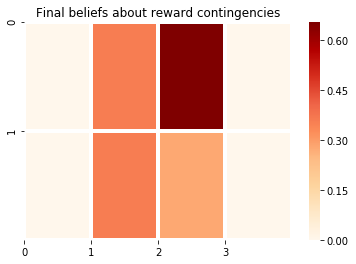

In [21]:
plot_likelihood(agent.A[1][1:,:,0],'Final beliefs about reward contingencies')

In [22]:
env.reward_condition

1

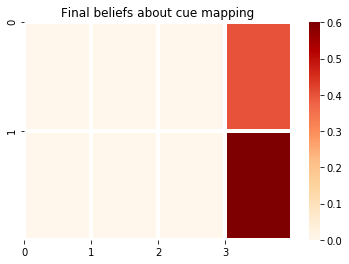

In [23]:
plot_likelihood(agent.A[2][1:,:,0],'Final beliefs about cue mapping')